### Feature extractions

This script extracted features from two sentimental corpora, kt4.0 (ours) and wisesight. By training from kt4.0 corpus, we expect to see an improvement in the wisesight corpus' classification performance.

Several feature extraction methods were applied on text feature to both corpuses as follows:  

* Bag of words for unigram and bigrams
* TF-IDF for unigram and bigrams
* Word2Vec with TF-IDF vector (300 dimension)
* POS_tagging with flatten dataframe for unigram and bigrams
* Dictionary-based with list of Thai positive and negative words for unigram and bigrams

Output:  
for all the feature extraction methods above, Joblib objects as numpy array and sparse matrix on text feature were dumped.     
pree.t@cmu.ac.th  

Todo: add thaitale corpuse  

In [24]:
import pandas as pd
import numpy as np
import pythainlp
import re
import emoji
from pythainlp import word_tokenize

# for visualize
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'tahoma'

## Load original datasets

In [25]:
import os
os.path.dirname(os.getcwd())

data_path_kt = os.path.dirname(os.getcwd()) + '\\data\kt4.0\\'
data_path_ws = os.path.dirname(os.getcwd()) + '\\data\wisesight\\'
model_path = os.path.dirname(os.getcwd()) + '\\model\\'
df_kt = pd.read_csv(data_path_kt + 'pantip_cleaned_1.csv')

# we use the original wisesight corpus and reconstruct a new dataframe
texts = []
targets = []

with open(str(data_path_ws) + '\\' + 'neg.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('neg')

with open(str(data_path_ws) + '\\' + 'neu.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('neu')

with open(str(data_path_ws) + '\\' + 'pos.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('pos')

with open(str(data_path_ws) + '\\' + 'q.txt', encoding='utf-8') as f:
    for line in f:
        texts.append(line.strip())
        targets.append('q')
        
df_ws = pd.DataFrame({'texts': texts, 'targets': targets})
df_ws.to_csv(os.path.dirname(os.getcwd()) + '\\' + 'wisesight.csv', index=False)
df_kt.shape, df_ws.shape

((60081, 14), (26737, 2))

In [26]:
y_kt = df_kt['vote'].astype('category').cat.codes
y_ws = df_ws['targets'].astype('category').cat.codes
y_kt.unique(), y_ws.unique()

(array([2, 0, 1], dtype=int8), array([0, 1, 2, 3], dtype=int8))

In [27]:
#y_kt.to_csv(os.path.dirname(os.getcwd()) + '\\' + 'label_kt.csv', index=False)
#y_ws.to_csv(os.path.dirname(os.getcwd()) + '\\' + 'label_ws.csv', index=False)

In [28]:
def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = text.strip('[link]') # remove [links]
    return text
    
def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def remove_word_len(text):
    new_list = [ word for word in text if len(word) >= 2 ]
    return new_list

def process_text(text):
    #pre rules
    res = remove_links(text)
    res = text.lower().strip()
    res = replace_rep(res)
    res = remove_emoji(res)
    
    #tokenize with the newmm algo. and get rid of whitespaces
    res = [word for word in word_tokenize(res, engine='newmm', keep_whitespace=False)if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = remove_word_len(res)
    return res

In [29]:
df_kt['processed'] = df_kt['text'].apply(str).apply(process_text)
df_ws['processed'] = df_ws['texts'].apply(str).apply(process_text)

In [30]:
df_kt.head(10)

,post_id,post_date,user_id,user_name,text,tag,emotion,length,num_sent,sent_length,label,label_1,label_2,vote,processed
0,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,[CR] แปังพัฟคุมมัน จัดเต็มเนื้อบางเบา,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,14,2,2,2,pos,"[cr, แป, ังพัฟ, คุม, มัน, จัด, เต็ม, เนื้อ, บา..."
1,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,ไม่อุดตัน แต่ปกปิดแน่นมาก,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,8,2,2,2,pos,"[ไม่, อุดตัน, แต่, ปกปิด, แน่น, มาก]"
2,39839097,2020-04-25 13:24:00,https://pantip.com/profile/5798163,สมาชิกหมายเลข 5798163,รีวิวแป้ง Lady Audrey Ready All Day จ้า,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,36,3,14,2,2,1,pos,"[รีวิว, แป้ง, lady, audrey, ready, all, day, จ้า]"
3,39838736,2020-04-25 10:52:00,https://pantip.com/profile/5730006,สมาชิกหมายเลข 5730006,ขอบตาดำมากค่ะ คอร์เล็คเตอร์ก็เอาไม่อยู่,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,15,2,13,1,3,3,neg,"[ขอบ, ตาดำ, มาก, ค่ะ, คอร์, เล็ค, เต, อร, ก็, ..."
4,39837384,2020-04-24 20:39:00,https://pantip.com/profile/4975838,สมาชิกหมายเลข 4975838,เอาaloe Vera แช่ตู้เย็น จนกลายเป็นน้ำแข็ง,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,11,1,11,1,1,3,neu,"[เอา, aloe, vera, แช่, ตู้เย็น, จน, กลายเป็น, ..."
5,39838990,2020-04-25 12:36:00,https://pantip.com/profile/5655853,chdewxx,[SR] ไอเทม #เซรั่มสิว ลดสิว สิวอุดตัน สิวผด บำ...,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,29,1,29,2,2,2,pos,"[sr, ไอเทม, เซ, รั่ม, สิว, ลด, สิว, สิว, อุดตั..."
6,39838619,2020-04-25 10:01:00,https://pantip.com/profile/5656639,คูจองยอนและวีรยา,รบกวนสาวๆช่วยแนะนำสกินแคร์ ที่ช่วยให้ผิวหน้าขา...,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,23,1,23,2,2,1,pos,"[รบกวน, สาว, ช่วย, แนะนำ, กิน, แคร์, ที่, ช่วย..."
7,39837266,2020-04-24 19:58:00,https://pantip.com/profile/632132,หมูกลมอารมณ์ดี,ทดลองใช้ แครอทวิตซีหน้าใส,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,2,9,1,2,2,pos,"[ทดลองใช้, แครอท, วิ, ซี, หน้า, ใส]"
8,39837266,2020-04-24 19:58:00,https://pantip.com/profile/632132,หมูกลมอารมณ์ดี,ใน 1 สัปดาห์,เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,2,5,1,1,1,neu,"[ใน, สัปดาห์]"
9,39835926,2020-04-24 12:03:00,https://pantip.com/profile/3826851,สมาชิกหมายเลข 3826851,"วิธีเลือก ""รองพื้น"" และ ""คอนซีลเลอร์""",เครื่องสำอาง,ถูกใจ 0 ขำกลิ้ง 0 หลงรัก 0 ซึ้ง 0 สยอง 0 ทึ่ง 0,14,1,14,2,2,2,pos,"[วิธี, เลือก, รองพื้น, และ, คอน, ซีล, เลอ, ร์""]"


In [31]:
df_kt.describe()

,post_id,length,num_sent,sent_length,label,label_1,label_2
count,6.008100e+04,60081.000000,60081.000000,60081.000000,60081.000000,60081.000000,60081.000000
mean,3.964936e+07,116.994574,8.502172,13.978329,1.577304,1.362644,1.662156
std,1.559919e+05,118.647716,7.575442,12.083572,0.777527,0.639271,0.800034
min,3.917283e+07,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,3.958755e+07,31.000000,3.000000,6.000000,1.000000,1.000000,1.000000
50%,3.968929e+07,72.000000,6.000000,10.000000,1.000000,1.000000,1.000000
75%,3.976947e+07,159.000000,11.000000,17.000000,2.000000,2.000000,2.000000
max,3.983970e+07,499.000000,44.000000,301.000000,3.000000,3.000000,3.000000


In [32]:
df_ws.tail(10)

,texts,targets,processed
26727,พี่ขวัญคะ ถ้าเรามี ซุลวาซุลเฟิร์สแคร์ กับ vich...,q,"[พี่, ขวัญ, คะ, ถ้า, เรา, มี, ซุล, วา, ซุลเฟิร..."
26728,มีสาวผิวเหลืองคนไหนลองใช้รองพื้นรุ่นใหม่ล่าสุด...,q,"[มี, สาว, ผิวเหลือง, คน, ไหน, ลอง, ใช้, รองพื้..."
26729,แอดมินคะ ทำไม True Money Wallet หักเงินคงเหลือ...,q,"[แอดมิน, คะ, ทำไม, true, money, wallet, หัก, เ..."
26730,แนะนำลิปของ cute press สีส้มอิฐหน่อยครับ อันไห...,q,"[แนะนำ, ลิป, ของ, cute, press, สีส้ม, อิฐ, หน่..."
26731,เวลาวิ่งที่ความเร็ว 80 ขึ้นไปพวงมาลัยจะสั่นครั...,q,"[เวลา, วิ่ง, ที่, ความเร็ว, 80, ขึ้นไป, พวงมาล..."
26732,วิธีซื้อรถมือสองต้องดูยังไงดีครับตอนนั้นพีจิมแ...,q,"[วิธี, ซื้อ, รถ, มือสอง, ต้อง, ดู, ยังไง, ดี, ..."
26733,- น้ำมันเครื่อง ทั้ง Fully / Semi เบนซิน - น้ำ...,q,"[น้ำมันเครื่อง, ทั้ง, fully, semi, เบนซิน, น้ำ..."
26734,Honda Civic Hatchback ที่มากับสีแดง ราคาเท่าเด...,q,"[honda, civic, hatchback, ที่มา, กับ, สีแดง, ร..."
26735,กำลังจะเริ่ม skincare 2 ตัวคือ stemfactor กับ ...,q,"[กำลังจะ, เริ่ม, skincare, ตัว, คือ, stemfacto..."
26736,พี่คะ หนูอยากสอบถามเรื่องนึงค่ะ อาจะไม่เกี่ยวก...,q,"[พี่, คะ, หนู, อยาก, สอบถาม, เรื่อง, นึง, ค่ะ,..."


In [33]:
df_ws.describe()

,texts,targets,processed
count,26737,26737,26737
unique,26713,4,26209
top,อุดรมีไหมค่ะ,neu,[]
freq,2,14561,56


In [34]:
# class distribution
df_kt.vote.value_counts() / df_kt.shape[0]

neu    0.633378
pos    0.205822
neg    0.160800
Name: vote, dtype: float64

In [35]:
# class distribution
df_ws.targets.value_counts() / df_ws.shape[0]

neu    0.544601
neg    0.255189
pos    0.178704
q      0.021506
Name: targets, dtype: float64

## Bag of words 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# BOW with unigram and bigrams
bow1 = CountVectorizer(tokenizer=process_text, ngram_range=(1, 1), min_df=5)
bow2 = CountVectorizer(tokenizer=process_text, ngram_range=(2, 2), min_df=5)

# fit kt and transform to both datasets
bow1_fit_kt = bow1.fit(df_kt['text'].apply(str))
text_bow1_kt = bow1_fit_kt.transform(df_kt['text'].apply(str))
text_bow1_ws = bow1_fit_kt.transform(df_ws['texts'].apply(str))

bow2_fit_kt = bow2.fit(df_kt['text'].apply(str))
text_bow2_kt = bow2_fit_kt.transform(df_kt['text'].apply(str))
text_bow2_ws = bow2_fit_kt.transform(df_ws['texts'].apply(str))

print(text_bow1_kt.toarray().shape,  text_bow1_kt.toarray().shape)
print(text_bow2_kt.toarray().shape,  text_bow2_kt.toarray().shape)

print(text_bow1_ws.toarray().shape,  text_bow1_ws.toarray().shape)
print(text_bow2_ws.toarray().shape,  text_bow2_ws.toarray().shape)

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(60081, 6475) (60081, 6475)
(60081, 17336) (60081, 17336)
(26737, 6475) (26737, 6475)
(26737, 17336) (26737, 17336)


In [37]:
#visualize texts
from visualize import top_feats_all, plot_top_feats
features = bow1_fit_kt.get_feature_names()
%time ts = top_feats_all(text_bow1_kt.toarray(), y_kt, features)
print(ts[0].shape)
ts[0].head()

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: total: 2.11 s
Wall time: 2.1 s
(6475, 5)


,rank,feature,score,ngram,label
0,0,ไม่,0.399959,1,0
1,1,ก็,0.246455,1,0
2,2,เลย,0.193562,1,0
3,3,เรา,0.173999,1,0
4,4,ค่ะ,0.172032,1,0


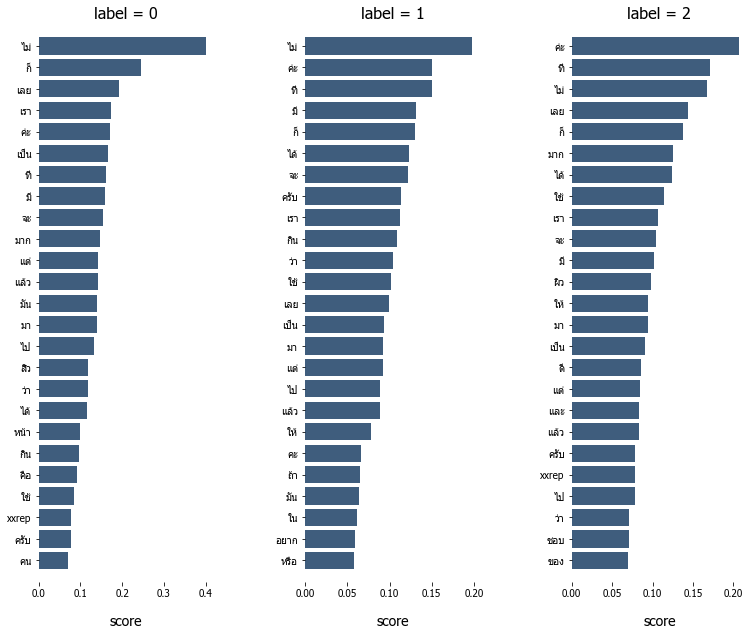

CPU times: total: 797 ms
Wall time: 783 ms


In [38]:
%time plot_top_feats(ts)

## TF-IDF

In [39]:
# TF-IDF with unigram and bigrams
tfidf1 = TfidfVectorizer(tokenizer=process_text, ngram_range=(1, 1), min_df=5)
tfidf2 = TfidfVectorizer(tokenizer=process_text, ngram_range=(2, 2), min_df=5)

# fit kt and transform to both datasets
tfidf1_fit_kt = tfidf1.fit(df_kt['text'].apply(str))
text_tfidf1_kt = tfidf1_fit_kt.transform(df_kt['text'].apply(str))
text_tfidf1_ws = tfidf1_fit_kt.transform(df_ws['texts'].apply(str))

tfidf2_fit_kt = tfidf2.fit(df_kt['text'].apply(str))
text_tfidf2_kt = tfidf2_fit_kt.transform(df_kt['text'].apply(str))
text_tfidf2_ws = tfidf2_fit_kt.transform(df_ws['texts'].apply(str))

print(text_tfidf1_kt.toarray().shape,  text_tfidf1_kt.toarray().shape)
print(text_tfidf2_kt.toarray().shape,  text_tfidf2_kt.toarray().shape)

print(text_tfidf1_ws.toarray().shape,  text_tfidf1_ws.toarray().shape)
print(text_tfidf2_ws.toarray().shape,  text_tfidf2_ws.toarray().shape)

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(60081, 6475) (60081, 6475)
(60081, 17336) (60081, 17336)
(26737, 6475) (26737, 6475)
(26737, 17336) (26737, 17336)


## Word2vec

In [40]:
from collections import Counter, defaultdict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, model):
        w2v = {w: vec for w, vec in zip(model.wv.index_to_key, model.wv.vectors)}
        self.word2vec = w2v
        self.word2weight = None
        self.dim = model.vector_size
    
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [41]:
import gensim
from pythainlp import word_vector
from gensim.models import Word2Vec, KeyedVectors

# create word2vec for kt corpus
w2v_kt = Word2Vec(vector_size=300, min_count=1, window=4, workers=4)
w2v_kt.build_vocab(df_kt['processed'])
w2v_kt.train(df_kt['processed'], total_examples=w2v_kt.corpus_count, epochs=100)
w2v_kt.wv.most_similar("บะหมี่")

[('กึ่ง', 0.5214864611625671),
 ('สำเร็จรูป', 0.4367881119251251),
 ('กิมจิ', 0.40023869276046753),
 ('ญวน', 0.40010714530944824),
 ('แซ่บ', 0.3995074927806854),
 ('ไส้กรอก', 0.38264161348342896),
 ('ต้มยำ', 0.3816748857498169),
 ('ราดหน้า', 0.3792392611503601),
 ('เป็ด', 0.3778884708881378),
 ('ผลไม้กระป๋อง', 0.37133264541625977)]

In [42]:
w2v_tfidf_emb_kt = TfidfEmbeddingVectorizer(w2v_kt)
w2v_tifdf_fit_kt = w2v_tfidf_emb_kt.fit(df_kt['text'].apply(str))

# transfrom on both corpuses
text_w2v_tfidf_kt = w2v_tifdf_fit_kt.transform(df_kt['text'].apply(str))
text_w2v_tfidf_ws = w2v_tifdf_fit_kt.transform(df_ws['texts'].apply(str))

## POS Tagging


In [43]:
def flatten(x):
    l = list(sum(x, ()))
    return l

In [44]:
from pythainlp.tag import pos_tag_sents
# we used a POS tag with the orchid_ud feature that represented a type of word in a sentence in one-hot vector form
# flatten the list of tuple in series was applied for feature vectors
df_kt['POSTags'] = pos_tag_sents(df_kt['processed'].tolist(), corpus='orchid_ud')
df_kt['POSTags'] = df_kt['POSTags'].apply(flatten)

df_ws['POSTags'] = pos_tag_sents(df_ws['processed'].tolist(), corpus='orchid_ud')
df_ws['POSTags'] = df_ws['POSTags'].apply(flatten)


# TODO: 1. concate word with pos via underscore (มัน_ADV)
#       2. use only tagging 
df_ws['POSTags'].iloc[0:10]

0     [☹️, NOUN]
1             []
2             []
3             []
4     [รำ, NOUN]
5     [no, NOUN]
6    [rip, NOUN]
7             []
8    [กาก, NOUN]
9    [โกง, NOUN]
Name: POSTags, dtype: object

In [45]:
df_ws['POSTags'].iloc[1220:1230]

1220    [ปิด, VERB, แร้ว, NOUN, xxrep, NOUN, เสีย, VER...
1221    [โป๊, NOUN, ไม่, PART, กิน, VERB, ช้าง, NOUN, ...
1222    [โปรด, NOUN, ระบุ, VERB, วัน, NOUN, เวลา, NOUN...
1223    [ผม, PRON, ชัก, NOUN, ไม่, PART, มั่นใจ, VERB,...
1224    [ผม, PRON, ว่า, SCONJ, ฮอนด้า, NOUN, กั๊ก, ADJ...
1225    [ผม, PRON, อยาก, AUX, ไห้, VERB, ประเทศ, NOUN,...
1226    [ผ่า, NOUN, พ้าม, VERB, แวะ, NOUN, มา, AUX, ตบ...
1227    [พนักงาน, NOUN, หน้าบึ้ง, NOUN, ไม่, PART, ยิ้...
1228    [รี, NOUN, อุ, NOUN, แบต, NOUN, ราคา, NOUN, สา...
1229    [พอแล้ว, SCONJ, นะ, VERB, เบียร์, NOUN, ช้าง, ...
Name: POSTags, dtype: object

In [46]:
# create bow vectors
text_pos_bow1_fit_kt = bow1.fit(df_kt['POSTags'].apply(str))
text_pos_bow1_kt = text_pos_bow1_fit_kt.transform(df_kt['POSTags'].apply(str))
text_pos_bow1_ws = text_pos_bow1_fit_kt.transform(df_ws['POSTags'].apply(str))

text_pos_bow2_fit_kt = bow2.fit(df_kt['POSTags'].apply(str))
text_pos_bow2_kt = text_pos_bow2_fit_kt.transform(df_kt['POSTags'].apply(str))
text_pos_bow2_ws = text_pos_bow2_fit_kt.transform(df_ws['POSTags'].apply(str))

print(text_pos_bow1_kt.toarray().shape,  text_pos_bow1_kt.toarray().shape)
print(text_pos_bow1_ws.toarray().shape,  text_pos_bow1_ws.toarray().shape)

print(text_pos_bow2_kt.toarray().shape,  text_pos_bow2_kt.toarray().shape)
print(text_pos_bow2_ws.toarray().shape,  text_pos_bow2_ws.toarray().shape)

C:\Users\Pree\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(60081, 6538) (60081, 6538)
(26737, 6538) (26737, 6538)
(60081, 13877) (60081, 13877)
(26737, 13877) (26737, 13877)


In [47]:
# create tfidf vectors
text_pos_tfidf1_fit_kt = tfidf1.fit(df_kt['POSTags'].apply(str))
text_pos_tfidf1_kt = text_pos_tfidf1_fit_kt.transform(df_kt['POSTags'].apply(str))
text_pos_tfidf1_ws = text_pos_tfidf1_fit_kt.transform(df_ws['POSTags'].apply(str))

text_pos_tfidf2_fit_kt = tfidf2.fit(df_kt['POSTags'].apply(str))
text_pos_tfidf2_kt = text_pos_tfidf2_fit_kt.transform(df_kt['POSTags'].apply(str))
text_pos_tfidf2_ws = text_pos_tfidf2_fit_kt.transform(df_ws['POSTags'].apply(str))

print(text_pos_tfidf1_kt.toarray().shape,  text_pos_tfidf1_kt.toarray().shape)
print(text_pos_tfidf1_ws.toarray().shape,  text_pos_tfidf1_ws.toarray().shape)

print(text_pos_tfidf2_kt.toarray().shape,  text_pos_tfidf2_kt.toarray().shape)
print(text_pos_tfidf2_ws.toarray().shape,  text_pos_tfidf2_ws.toarray().shape)

(60081, 6538) (60081, 6538)
(26737, 6538) (26737, 6538)
(60081, 13877) (60081, 13877)
(26737, 13877) (26737, 13877)


## Dictionary-based

In [48]:
# load list of our custom positive and negative words
with open(os.path.dirname(os.getcwd()) + '\\data\\' + 'pos_words.txt', encoding='UTF-8') as f:
    pos_words = [line.rstrip('\n') for line in f]

with open(os.path.dirname(os.getcwd()) + '\\data\\' + 'neg_words.txt', encoding='UTF-8') as f:
    neg_words = [line.rstrip('\n') for line in f]
pos_words = list(set(pos_words))
neg_words = list(set(neg_words))

In [49]:
bow1 = CountVectorizer(tokenizer=process_text, ngram_range=(1, 1))
bow2 = CountVectorizer(tokenizer=process_text, ngram_range=(2, 2))

my_vocabs = pos_words + neg_words
print('dict size: ', len(my_vocabs))

text_dict_bow1_fit = bow1.fit(my_vocabs)
text_dict_bow1_kt = text_dict_bow1_fit.transform(df_kt['text'].apply(str))
text_dict_bow1_ws = text_dict_bow1_fit.transform(df_ws['texts'].apply(str))

text_dict_bow2_fit = bow2.fit(my_vocabs)
text_dict_bow2_kt = text_dict_bow2_fit.transform(df_kt['text'].apply(str))
text_dict_bow2_ws = text_dict_bow2_fit.transform(df_ws['texts'].apply(str))

print(text_dict_bow1_kt.toarray().shape,  text_dict_bow1_kt.toarray().shape)
print(text_dict_bow1_ws.toarray().shape,  text_dict_bow1_ws.toarray().shape)

print(text_dict_bow2_kt.toarray().shape,  text_dict_bow2_kt.toarray().shape)
print(text_dict_bow2_ws.toarray().shape,  text_dict_bow2_ws.toarray().shape)

dict size:  91
(60081, 100) (60081, 100)
(26737, 100) (26737, 100)
(60081, 33) (60081, 33)
(26737, 33) (26737, 33)


In [50]:
tfidf1 = TfidfVectorizer(tokenizer=process_text, ngram_range=(1, 1))
tfidf2 = TfidfVectorizer(tokenizer=process_text, ngram_range=(2, 2))

text_dict_tfidf1_fit = tfidf1.fit(my_vocabs)
text_dict_tfidf1_kt = text_dict_tfidf1_fit.transform(df_kt['text'].apply(str))
text_dict_tfidf1_ws = text_dict_tfidf1_fit.transform(df_ws['texts'].apply(str))

text_dict_tfidf2_fit = tfidf2.fit(my_vocabs)
text_dict_tfidf2_kt = text_dict_tfidf2_fit.transform(df_kt['text'].apply(str))
text_dict_tfidf2_ws = text_dict_tfidf2_fit.transform(df_ws['texts'].apply(str))

print(text_dict_tfidf1_kt.toarray().shape,  text_dict_tfidf1_kt.toarray().shape)
print(text_dict_tfidf1_ws.toarray().shape,  text_dict_tfidf1_ws.toarray().shape)

print(text_dict_tfidf2_kt.toarray().shape,  text_dict_tfidf2_kt.toarray().shape)
print(text_dict_tfidf2_ws.toarray().shape,  text_dict_tfidf2_ws.toarray().shape)

(60081, 100) (60081, 100)
(26737, 100) (26737, 100)
(60081, 33) (60081, 33)
(26737, 33) (26737, 33)


## Save to disk

In [51]:
import scipy
import joblib
from scipy import sparse

y_t_kt = y_kt.to_numpy().reshape(-1, 1)
y_t_ws = y_ws.to_numpy().reshape(-1, 1)

y_t_kt = sparse.csr_matrix(y_t_kt)
y_t_ws = sparse.csr_matrix(y_t_ws)
# dump as nparray
# arr_bow1_kt = np.concatenate((text_bow1_kt.toarray(), y_t_kt), axis= 1)
# arr_bow2_kt = np.concatenate((text_bow2_kt.toarray(), y_t_kt), axis= 1)

# # 20k dims is too big when using savetxt, we need to compress
# #np.savetext('text_bow1_kt.csv', mat, delimiter=',')
# joblib.dump(arr_bow1_kt, model_path+'text_bow1_kt.joblib')
# joblib.dump(arr_bow2_kt, model_path+'text_bow2_kt.joblib')

# dump sparse matrix
# df_bow1_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_bow1_kt), y_kt], axis=1)
# df_bow2_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_bow2_kt), y_kt], axis=1)
# joblib.dump(df_bow1_kt, model_path+'text_bow1_kt.pkl')
# joblib.dump(df_bow2_kt, model_path+'text_bow2_kt.pkl')


arr_bow1_kt = np.hstack((text_bow1_kt, y_t_kt))
arr_bow2_kt = np.hstack((text_bow2_kt, y_t_kt))
joblib.dump(arr_bow1_kt, model_path+'text_bow1_kt.pkl')
joblib.dump(arr_bow2_kt, model_path+'text_bow2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_bow2_kt.pkl']

In [52]:
# arr_bow1_ws = np.concatenate((text_bow1_ws.toarray(), y_t_kt), axis= 1)
# arr_bow2_ws = np.concatenate((text_bow2_ws.toarray(), y_t_kt), axis= 1)

# joblib.dump(arr_bow1_ws, model_path+'text_bow1_ws.joblib')
# joblib.dump(arr_bow2_ws, model_path+'text_bow2_ws.joblib')

# dump sparse matrix
# df_bow1_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_bow1_ws), y_ws], axis=1)
# df_bow2_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_bow2_ws), y_ws], axis=1)
# joblib.dump(df_bow1_ws, model_path+'text_bow1_ws.pkl')
# joblib.dump(df_bow2_ws, model_path+'text_bow2_ws.pkl')

arr_bow1_ws = np.hstack((text_bow1_ws, y_t_ws))
arr_bow2_ws = np.hstack((text_bow2_ws, y_t_ws))
joblib.dump(arr_bow1_ws, model_path+'text_bow1_ws.pkl')
joblib.dump(arr_bow2_ws, model_path+'text_bow2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_bow2_ws.pkl']

In [53]:
#arr_tfidf1_kt = np.concatenate((text_tfidf1_kt.toarray(), y_t_kt), axis= 1)
#arr_tfidf2_kt = np.concatenate((text_tfidf2_kt.toarray(), y_t_kt), axis= 1)
#np.savetext('text_bow1_kt.csv', mat, delimiter=',')
# joblib.dump(arr_tfidf1_kt, model_path+'text_tfidf1_kt.joblib')
# joblib.dump(arr_tfidf2_kt, model_path+'text_tfidf2_kt.joblib')

# dump sparse matrix
# df_tfidf1_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_tfidf1_kt), y_kt], axis=1)
# df_tfidf2_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_tfidf2_kt), y_kt], axis=1)
# joblib.dump(df_tfidf1_kt, model_path+'text_tfidf1_kt.pkl')
# joblib.dump(df_tfidf2_kt, model_path+'text_tfidf2_kt.pkl')

arr_tfidf1_kt = np.hstack((text_tfidf1_kt, y_t_kt))
arr_tfidf2_kt = np.hstack((text_tfidf2_kt, y_t_kt))
joblib.dump(arr_tfidf1_kt, model_path+'text_tfidf1_kt.pkl')
joblib.dump(arr_tfidf2_kt, model_path+'text_tfidf2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_tfidf2_kt.pkl']

In [54]:
# arr_tfidf1_ws = np.concatenate((text_tfidf1_ws.toarray(), y_ws_arr), axis= 1)
# arr_tfidf2_ws = np.concatenate((text_tfidf2_ws.toarray(), y_ws_arr), axis= 1)

# joblib.dump(arr_tfidf1_ws, model_path+'text_tfidf1_ws.joblib')
# joblib.dump(arr_tfidf2_ws, model_path+'text_tfidf2_ws.joblib')

# # dump sparse matrix
# df_tfidf1_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_tfidf1_ws), y_ws], axis=1)
# df_tfidf2_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_tfidf2_ws), y_ws], axis=1)
# joblib.dump(df_tfidf1_ws, model_path+'text_tfidf1_ws.pkl')
# joblib.dump(df_tfidf2_ws, model_path+'text_tfidf2_ws.pkl')

arr_tfidf1_ws = np.hstack((text_tfidf1_ws, y_t_ws))
arr_tfidf2_ws = np.hstack((text_tfidf2_ws, y_t_ws))
joblib.dump(arr_tfidf1_ws, model_path+'text_tfidf1_ws.pkl')
joblib.dump(arr_tfidf2_ws, model_path+'text_tfidf2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_tfidf2_ws.pkl']

In [55]:
# arr_w2v_tfidf_kt = np.concatenate((text_w2v_tfidf_kt, y_kt_arr), axis= 1)
# arr_w2v_tfidf_ws = np.concatenate((text_w2v_tfidf_ws, y_ws_arr), axis= 1)

# joblib.dump(arr_w2v_tfidf_kt, model_path+'text_w2v_tfidf_kt.joblib')
# joblib.dump(arr_w2v_tfidf_ws, model_path+'text_w2v_tfidf_ws.joblib')

# df_w2v_tfidf_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(sparse.csr_matrix(text_w2v_tfidf_kt)), y_kt], axis=1)
# df_w2v_tfidf_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(sparse.csr_matrix(text_w2v_tfidf_ws)), y_ws], axis=1)
# joblib.dump(df_w2v_tfidf_kt, model_path+'text_w2v_tfidf_kt.pkl')
# joblib.dump(df_w2v_tfidf_ws, model_path+'text_w2v_tfidf_ws.pkl')

arr_w2v_tfidf_kt = np.hstack(( sparse.csr_matrix(text_w2v_tfidf_kt), y_t_kt))
arr_w2v_tfidf_ws = np.hstack(( sparse.csr_matrix(text_w2v_tfidf_ws), y_t_ws))
joblib.dump(arr_w2v_tfidf_kt, model_path+'text_w2v_tfidf_kt.pkl')
joblib.dump(arr_w2v_tfidf_ws, model_path+'text_w2v_tfidf_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_w2v_tfidf_ws.pkl']

In [56]:
# arr_pos_bow1_kt = np.concatenate((text_pos_bow1_kt.toarray(), y_kt_arr), axis= 1)
# arr_pos_bow2_kt = np.concatenate((text_pos_bow2_kt.toarray(), y_kt_arr), axis= 1)

# joblib.dump(arr_pos_bow1_kt, model_path+'text_pos_bow1_kt.joblib')
# joblib.dump(arr_pos_bow2_kt, model_path+'text_pos_bow2_kt.joblib')

# # dump sparse matrix
# df_text_pos_bow1_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow1_kt), y_kt], axis=1)
# df_text_pos_bow2_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow2_kt), y_kt], axis=1)
# joblib.dump(df_text_pos_bow1_kt, model_path+'text_pos_bow1_kt.pkl')
# joblib.dump(df_text_pos_bow2_kt, model_path+'text_pos_bow2_kt.pkl')

arr_pos_bow1_kt = np.hstack((text_pos_bow1_kt, y_t_kt))
arr_pos_bow2_kt = np.hstack((text_pos_bow2_kt, y_t_kt))
joblib.dump(arr_pos_bow1_kt, model_path+'text_pos_bow1_kt.pkl')
joblib.dump(arr_pos_bow2_kt, model_path+'text_pos_bow2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_pos_bow2_kt.pkl']

In [57]:
# arr_pos_bow1_ws = np.concatenate((text_pos_bow1_ws.toarray(), y_ws_arr), axis= 1)
# arr_pos_bow2_ws = np.concatenate((text_pos_bow2_ws.toarray(), y_ws_arr), axis= 1)

# joblib.dump(arr_pos_bow1_ws, model_path+'text_pos_bow1_ws.joblib')
# joblib.dump(arr_pos_bow2_ws, model_path+'text_pos_bow2_ws.joblib')

# # dump sparse matrix
# df_text_pos_bow1_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow1_ws), y_ws], axis=1)
# df_text_pos_bow2_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow2_ws), y_ws], axis=1)
# joblib.dump(df_text_pos_bow1_ws, model_path+'text_pos_bow1_ws.pkl')
# joblib.dump(df_text_pos_bow2_ws, model_path+'text_pos_bow2_ws.pkl')

arr_pos_bow1_ws = np.hstack((text_pos_bow1_ws, y_t_ws))
arr_pos_bow2_ws = np.hstack((text_pos_bow2_ws, y_t_ws))
joblib.dump(arr_pos_bow1_ws, model_path+'text_pos_bow1_ws.pkl')
joblib.dump(arr_pos_bow2_ws, model_path+'text_pos_bow2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_pos_bow2_ws.pkl']

In [58]:
arr_pos_tfidf1_kt = np.hstack((text_pos_tfidf1_kt, y_t_kt))
arr_pos_tfidf2_kt = np.hstack((text_pos_tfidf2_kt, y_t_kt))
joblib.dump(arr_pos_tfidf1_kt, model_path+'text_pos_tfidf1_kt.pkl')
joblib.dump(arr_pos_tfidf2_kt, model_path+'text_pos_tfidf2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_pos_tfidf2_kt.pkl']

In [59]:
arr_pos_tfidf1_ws = np.hstack((text_pos_tfidf1_ws, y_t_ws))
arr_pos_tfidf2_ws = np.hstack((text_pos_tfidf2_ws, y_t_ws))
joblib.dump(arr_pos_tfidf1_ws, model_path+'text_pos_tfidf1_ws.pkl')
joblib.dump(arr_pos_tfidf2_ws, model_path+'text_pos_tfidf2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_pos_tfidf2_ws.pkl']

In [60]:
# arr_dict_bow1_kt = np.concatenate((text_pos_bow1_kt.toarray(), y_kt_arr), axis= 1)
# arr_dict_bow2_kt = np.concatenate((text_pos_bow2_kt.toarray(), y_kt_arr), axis= 1)

# joblib.dump(arr_dict_bow1_kt, model_path+'text_dict_bow1_kt.joblib')
# joblib.dump(arr_dict_bow2_kt, model_path+'text_dict_bow2_kt.joblib')

# # dump sparse matrix
# df_text_pos_bow1_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow1_kt), y_kt], axis=1)
# df_text_pos_bow2_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow2_kt), y_kt], axis=1)
# joblib.dump(df_text_pos_bow1_kt, model_path+'text_pos_bow1_kt.pkl')
# joblib.dump(df_text_pos_bow2_kt, model_path+'text_pos_bow2_kt.pkl')

arr_dict_bow1_kt = np.hstack((text_dict_bow1_kt, y_t_kt))
arr_dict_bow2_kt = np.hstack((text_dict_bow2_kt, y_t_kt))
joblib.dump(arr_dict_bow1_kt, model_path+'text_dict_bow1_kt.pkl')
joblib.dump(arr_dict_bow2_kt, model_path+'text_dict_bow2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_dict_bow2_kt.pkl']

In [61]:
# arr_dict_bow1_ws = np.concatenate((text_dict_bow1_ws.toarray(), y_ws_arr), axis= 1)
# arr_dict_bow2_ws = np.concatenate((text_dict_bow2_ws.toarray(), y_ws_arr), axis= 1)

# joblib.dump(arr_dict_bow1_ws, model_path+'text_dict_bow1_ws.joblib')
# joblib.dump(arr_dict_bow2_ws, model_path+'text_dict_bow2_ws.joblib')

# # dump sparse matrix
# df_text_pos_bow1_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow1_ws), y_ws], axis=1)
# df_text_pos_bow2_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_pos_bow2_ws), y_ws], axis=1)
# joblib.dump(df_text_pos_bow1_ws, model_path+'text_pos_bow1_ws.pkl')
# joblib.dump(df_text_pos_bow2_ws, model_path+'text_pos_bow2_ws.pkl')

arr_dict_bow1_ws = np.hstack((text_dict_bow1_ws, y_t_ws))
arr_dict_bow2_ws = np.hstack((text_dict_bow2_ws, y_t_ws))
joblib.dump(arr_dict_bow1_ws, model_path+'text_dict_bow1_ws.pkl')
joblib.dump(arr_dict_bow2_ws, model_path+'text_dict_bow2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_dict_bow2_ws.pkl']

In [62]:
# arr_dict_tfidf1_kt = np.concatenate((text_dict_tfidf1_kt.toarray(), y_kt_arr), axis= 1)
# arr_dict_tfidf2_kt = np.concatenate((text_dict_tfidf1_kt.toarray(), y_kt_arr), axis= 1)

# joblib.dump(arr_dict_tfidf1_kt, model_path+'text_dict_tfidf1_kt.joblib')
# joblib.dump(arr_dict_tfidf2_kt, model_path+'text_dict_tfidf2_kt.joblib')

# # dump sparse matrix
# df_dict_tfidf1_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_dict_tfidf1_kt), y_kt], axis=1)
# df_dict_tfidf2_kt = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_dict_tfidf2_kt), y_kt], axis=1)
# joblib.dump(df_dict_tfidf1_kt, model_path+'text_dict_tfidf1_kt.pkl')
# joblib.dump(df_dict_tfidf2_kt, model_path+'text_dict_tfidf2_kt.pkl')

arr_dict_tfidf1_kt = np.hstack((text_dict_tfidf1_kt, y_t_kt))
arr_dict_tfidf2_kt = np.hstack((text_dict_tfidf2_kt, y_t_kt))
joblib.dump(arr_dict_tfidf1_kt, model_path+'text_dict_tfidf1_kt.pkl')
joblib.dump(arr_dict_tfidf2_kt, model_path+'text_dict_tfidf2_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_dict_tfidf2_kt.pkl']

In [63]:
# arr_dict_tfidf1_ws = np.concatenate((text_dict_tfidf1_ws.toarray(), y_ws_arr), axis= 1)
# arr_dict_tfidf2_ws = np.concatenate((text_dict_tfidf1_ws.toarray(), y_ws_arr), axis= 1)

# joblib.dump(arr_dict_tfidf1_ws, model_path+'text_dict_tfidf1_ws.joblib')
# joblib.dump(arr_dict_tfidf2_ws, model_path+'text_dict_tfidf2_ws.joblib')

# # dump sparse matrix
# df_dict_tfidf1_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_dict_tfidf1_ws), y_ws], axis=1)
# df_dict_tfidf2_ws = pd.concat([pd.DataFrame.sparse.from_spmatrix(text_dict_tfidf2_ws), y_ws], axis=1)
# joblib.dump(df_dict_tfidf1_ws, model_path+'text_dict_tfidf1_ws.pkl')
# joblib.dump(df_dict_tfidf2_ws, model_path+'text_dict_tfidf2_ws.pkl')

arr_dict_tfidf1_ws = np.hstack((text_dict_tfidf1_ws, y_t_ws))
arr_dict_tfidf2_ws = np.hstack((text_dict_tfidf2_ws, y_t_ws))
joblib.dump(arr_dict_tfidf1_ws, model_path+'text_dict_tfidf1_ws.pkl')
joblib.dump(arr_dict_tfidf2_ws, model_path+'text_dict_tfidf2_ws.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_dict_tfidf2_ws.pkl']

## Demonstrate usage


In [ ]:
# load kt corpus extracted features array 
#arr_kt = np.load(model_path+'text_tfidf2_kt.joblib')
arr_kt = joblib.load(model_path+'text_tfidf2_kt.pkl')
arr_kt

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
train_df, test_df = train_test_split(arr_kt.toarray, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

## Train-valid split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

## Test the extracted features with Logistic Regression

In [ ]:
# quick test with out cv
#fit logistic regression models
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train, y_train)
model.score(X_valid, y_valid)
#y_pred = model.predict(X_valid)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
def build_model(model):
    scores = (cross_val_score(model, X_train, y_train, cv = 5).mean())
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc_sc = accuracy_score(y_valid, y_pred)
    pre_sc = precision_score(y_valid, y_pred, average='weighted')
    rec_sc = recall_score(y_valid, y_pred, average='weighted')
    f1_sc = f1_score(y_valid, y_pred, average='weighted')
    print('Accuracy :',acc_sc)
    print('Confusion Matrix :\n', confusion_matrix(y_valid, y_pred))
    print('Precision :', pre_sc)
    print('Recall :', rec_sc)
    print('F1-score :', f1_sc)
    print('Classification Report :\n', classification_report(y_valid, y_pred))
    print('Average accuracy of k-fold (5-fold) :', scores ,'\n')

In [ ]:
build_model(model)

In [ ]:
# predict on kt dataset
#arr_ws = np.load(model_path+'text_tfidf2_ws.npy')
arr_ws = joblib.load(model_path+'text_tfidf2_ws.pkl')
arr_ws.shape

In [ ]:
train_df, test_df = train_test_split(arr_ws.to_numpy(), test_size=0.20, random_state=42)
train_df.shape, test_df.shape

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [ ]:
build_model(model)